In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()

In [2]:
# data transform
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
data_dir = 'Data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [4]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_acc = []
    valid_acc = []
    train_loss = []
    valid_loss = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc, train_loss, valid_acc, valid_loss

In [15]:
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
# for param in resnet.parameters():
#     param.requires_grad = False
resnet.fc = nn.Linear(num_ftrs, len(class_names))
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Observe that all parameters are being optimized
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
resnet, train_acc, train_loss, valid_acc, valid_loss = train_model(resnet,
                                        criterion, optimizer,exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8512 Acc: 0.6443
val Loss: 0.9392 Acc: 0.5515

Epoch 1/24
----------
train Loss: 0.7730 Acc: 0.6833
val Loss: 0.7063 Acc: 0.6828

Epoch 2/24
----------
train Loss: 0.7000 Acc: 0.7152
val Loss: 0.5256 Acc: 0.7912

Epoch 3/24
----------
train Loss: 0.6958 Acc: 0.7161
val Loss: 0.5481 Acc: 0.7843

Epoch 4/24
----------
train Loss: 0.6665 Acc: 0.7218
val Loss: 0.5802 Acc: 0.8018

Epoch 5/24
----------
train Loss: 0.6366 Acc: 0.7469
val Loss: 0.5434 Acc: 0.7811

Epoch 6/24
----------
train Loss: 0.5996 Acc: 0.7564
val Loss: 0.5586 Acc: 0.8045

Epoch 7/24
----------
train Loss: 0.5046 Acc: 0.7995
val Loss: 0.4356 Acc: 0.8284

Epoch 8/24
----------
train Loss: 0.5066 Acc: 0.7954
val Loss: 0.4280 Acc: 0.8358

Epoch 9/24
----------
train Loss: 0.4918 Acc: 0.8031
val Loss: 0.4284 Acc: 0.8332

Epoch 10/24
----------
train Loss: 0.4770 Acc: 0.8027
val Loss: 0.4242 Acc: 0.8321

Epoch 11/24
----------
train Loss: 0.4761 Acc: 0.8102
val Loss: 0.4221 Acc: 0.8294

Ep

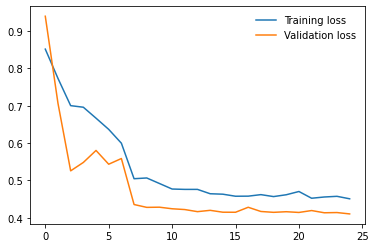

In [16]:
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend(frameon=False)
plt.show()

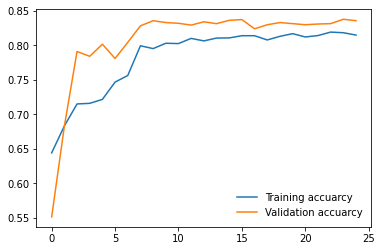

In [17]:
plt.plot(train_acc, label='Training accuarcy')
plt.plot(valid_acc, label='Validation accuarcy')
plt.legend(frameon=False)
plt.show()

In [18]:
predicted = []
labels = []
for data, label in dataloaders["val"]:
    outputs = resnet(data)
    _, preds = torch.max(outputs, 1)
    labels.extend(label.tolist())
    predicted.extend(preds.tolist())
print(len(predicted))
print(len(labels))

1882
1882


In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
print(classification_report(labels, predicted, target_names=class_names))
cmf = confusion_matrix(labels,predicted,normalize="true")
cmf = pd.DataFrame(cmf, 
  index = class_names,
  columns = class_names)

                 precision    recall  f1-score   support

       COVID-19       0.85      0.93      0.89       112
         Normal       0.92      0.95      0.94       479
Pnemonia_others       0.75      0.64      0.69       451
   non-COVID-19       0.83      0.87      0.85       840

       accuracy                           0.84      1882
      macro avg       0.84      0.85      0.84      1882
   weighted avg       0.83      0.84      0.83      1882



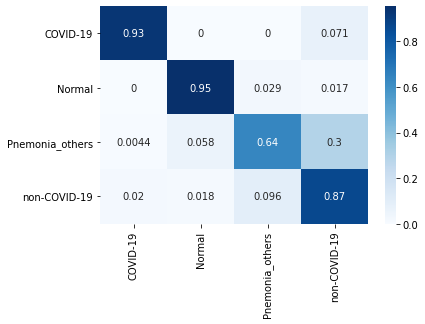

In [20]:
sns.heatmap(cmf, cmap='Blues',annot=True)